In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
import matplotlib.pyplot as plt 
from scipy.stats import shapiro
import scipy.stats as st
from scipy.stats import bartlett

## Construction de notre échantillon de données

In [2]:
test = pd.read_csv('fr_population.csv')
disponibilites = pd.read_csv('disponibilites.csv')
population = pd.read_csv('population.csv')
poulet = pd.read_csv('imp_poulets.csv')
volailles = pd.read_csv('volailles.csv')
pib = pd.read_csv('pib.csv')

In [3]:
chine = test[test.Zone == 'Chine']
index_chine = chine.index
test.drop(index_chine,inplace=True)

In [4]:
test = test[['Code zone', 'Zone']]

#### Le PIB de chaque pays

In [5]:
pib = pib[['Code zone (FAO)', 'Valeur']]
pib.Valeur = round(pib.Valeur)
pib.Valeur = pib.Valeur.astype(int)
pib.rename(columns={'Valeur':'PIB par habitant en dollar US','Code zone (FAO)':'Code zone'}, inplace=True)

In [6]:
pib

,Code zone,PIB par habitant en dollar US
0,2,470
1,202,6001
2,3,5303
3,4,3976
4,79,46232
...,...,...
205,236,4733
206,237,2715
207,249,855
208,251,1292


#### Traitement des données des disponibilités alimentaires

In [7]:
disponibilites = disponibilites[['Code zone', '?l?ment', 'Produit', 'Valeur']]
dispo_df = disponibilites.pivot_table(index=['Code zone', 'Produit'], columns='?l?ment', values='Valeur').reset_index()
dispo_df.rename(columns={'Disponibilit? alimentaire (Kcal/personne/jour)':'dispo_alim_kcal_ppj','Disponibilit? de prot?ines en quantit? (g/personne/jour)':'dispo_prot_g_ppj'}, inplace=True)

In [8]:
dispo_anim = dispo_df[dispo_df.Produit == 'Produits Animaux']
dispo_anim = dispo_anim[['Code zone', 'dispo_prot_g_ppj']]
dispo_anim.rename(columns={'dispo_alim_kcal_ppj':'dispo_alim_kcal_ppj_anim', 'dispo_prot_g_ppj': 'dispo_prot_g_ppj_anim'}, inplace=True)
dispo_tot = dispo_df[dispo_df.Produit == 'Total General']
dispo_tot = dispo_tot[['Code zone', 'dispo_alim_kcal_ppj', 'dispo_prot_g_ppj']]
dispo_tot.rename(columns={'dispo_alim_kcal_ppj':'dispo_alim_kcal_ppj_tot', 'dispo_prot_g_ppj': 'dispo_prot_g_ppj_tot'}, inplace=True)

In [9]:
dispo = dispo_anim.merge(dispo_tot, on='Code zone')
dispo['ratio_prot_anim'] = dispo['dispo_prot_g_ppj_anim']/dispo['dispo_prot_g_ppj_tot']*100
dispo = dispo[['Code zone', 'dispo_alim_kcal_ppj_tot', 'dispo_prot_g_ppj_tot', 'ratio_prot_anim']]

In [10]:
dispo.sort_values(by='dispo_prot_g_ppj_tot', ascending=False)

?l?ment,Code zone,dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim
66,99,3637.0,143.94,72.690010
63,96,3236.0,129.45,74.662032
72,105,3558.0,126.10,60.563045
125,174,3458.0,117.74,63.912010
45,67,3320.0,117.47,62.152039
...,...,...,...,...
159,226,2156.0,43.14,23.435327
93,129,1912.0,42.66,20.768870
89,123,2149.0,42.11,25.314652
128,181,1707.0,38.21,27.375033


#### Traitement des données de la population mondiale

In [11]:
population = population[['Code zone (FAO)', 'Zone', 'Ann?e', 'Valeur']]
population.Valeur = population.Valeur*1000
population.Valeur = population.Valeur.astype(int)
population['Ann?e'] = population['Ann?e'].astype(str)
pop_df = population.pivot_table(index=['Code zone (FAO)', 'Zone'], columns='Ann?e', values='Valeur').reset_index()
pop_df.rename(columns={'Code zone (FAO)':'Code zone', '2015':'Population 2015', '2019': 'Population 2019'}, inplace=True)
pop_df['var_pop(2015)'] = (pop_df['Population 2019']-pop_df['Population 2015'])/pop_df['Population 2019']*100

In [12]:
pop_df = pop_df[['Code zone', 'Zone', 'Population 2019', 'var_pop(2015)']]
pop_df

Ann?e,Code zone,Zone,Population 2019,var_pop(2015)
0,1,Arm?nie,2957731,1.087929
1,2,Afghanistan,38041754,9.537286
2,3,Albanie,2880917,-0.333088
3,4,Alg?rie,43053054,7.723097
4,5,Samoa am?ricaines,55312,-0.903963
...,...,...,...,...
231,279,Cura?ao,163424,2.188785
232,280,Sint Maarten (partie n?erlandaise),42388,5.709163
233,281,Saint-Martin (partie fran?aise),38002,5.641808
234,282,Saint-Barth?lemy,9847,1.563928


#### Traitement des données spécifiques à la volaille

In [13]:
vol_pivot = volailles.pivot_table(index=['Code zone'], columns='?l?ment', values='Valeur').reset_index()
vol_pivot.rename(columns={'Disponibilit? int?rieure':'Dispo_int_vol(en milliers de tonnes)'}, inplace=True)
vol_pivot.rename(columns={'Importations - Quantit?':'Imp_vol(en milliers de tonnes)'}, inplace=True) 
vol_pivot.rename(columns={'Production':'Prod_vol(en milliers de tonnes)'}, inplace=True)

In [14]:
vol_pivot

?l?ment,Code zone,Dispo_int_vol(en milliers de tonnes),Imp_vol(en milliers de tonnes),Prod_vol(en milliers de tonnes)
0,1,55.0,43.0,12.0
1,2,67.0,44.0,28.0
2,3,34.0,22.0,12.0
3,4,287.0,0.0,291.0
4,7,327.0,278.0,49.0
...,...,...,...,...
173,255,187.0,320.0,448.0
174,256,12.0,12.0,0.0
175,272,112.0,17.0,104.0
176,273,10.0,7.0,4.0


In [15]:
poulet.Valeur = poulet.Valeur*1000
poulet = poulet[['Code zone (FAO)', 'Valeur']]

In [16]:
poulet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code zone (FAO)  180 non-null    int64  
 1   Valeur           179 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.9 KB


#### Présence de valeurs manquantes, nous allons donc y regarder de plus près.

In [17]:
poulet.index[poulet.isna().any(axis=1)]

Int64Index([175], dtype='int64')

In [18]:
vol_pivot.index[vol_pivot.isna().any(axis=1)]

Int64Index([48, 96, 166], dtype='int64')

In [19]:
vol_pivot.loc[[48, 96, 166]]

?l?ment,Code zone,Dispo_int_vol(en milliers de tonnes),Imp_vol(en milliers de tonnes),Prod_vol(en milliers de tonnes)
48,72,3.0,3.0,NaN
96,132,12.0,11.0,NaN
166,236,428.0,NaN,428.0


In [20]:
poulet.loc[[175]]

,Code zone (FAO),Valeur
175,236,NaN


#### Pour les zones 72 et 236, leur disponibilité intérieure concernant les viandes de volailles est parfaitement égal à leur quantité d'importation et de production respectivement. Rappelons que la disponibilité intérieure est égale à la production plus les importations moins les exportations. Sachant cela, nous pouvons conclure sans problème que la zone 72 ne produit pas de volaille et que la zone 236 n'en importe pas. Concernant la zone 132, qui correspond aux Maldives, étant donné qu'ils pratiquent l'élevage de poulets, ils produisent par conséquent de la viande de volailles. Nous pouvons donc remplacer leur valeur manquante en production par 1000 tonnes.

In [21]:
vol_pivot.loc[48, 'Prod_vol(en milliers de tonnes)']= 0
vol_pivot.loc[96, 'Prod_vol(en milliers de tonnes)']= 1
vol_pivot.loc[166, 'Imp_vol(en milliers de tonnes)']= 0
poulet.loc[175, 'Valeur'] = 0

In [22]:
poulet.rename(columns={'Code zone (FAO)':'Code zone'}, inplace=True)
poulet.rename(columns={'Valeur':'Importation en dollars'}, inplace=True) 

#### Nous allons maintenant définir une variable que nous appellerons taux_prod, qui correspond au rapport de la production sur la disponibilité intérieure.
#### Plus ce taux sera proche de 0, moins le pays sera autosuffisant et donc il sera plus enclin à importer du poulet.

In [23]:
#vol_pivot['taux_imp'] = vol_pivot['Imp_vol(en tonnes)']/vol_pivot['Dispo_int_vol(en tonnes)']*100
vol_pivot['taux_prod'] = vol_pivot['Prod_vol(en milliers de tonnes)']/vol_pivot['Dispo_int_vol(en milliers de tonnes)']*100
vol_pivot = vol_pivot[['Code zone', 'taux_prod']]

## Création de notre dataframe final

In [24]:
df1 = pop_df.merge(dispo, on='Code zone')
df2 = df1.merge(pib, on='Code zone')
df3 = df2.merge(poulet, on='Code zone')
df4 = df3.merge(vol_pivot, on='Code zone')

In [25]:
data = test.merge(df4, on='Code zone', how='right')

In [26]:
data.loc[data.isna().any(axis=1)]

,Code zone,Zone_x,Zone_y,Population 2019,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod
17,29,NaN,Burundi,11530580,11.886219,1825.0,43.35,7.081892,260,160000.0,100.000000
27,45,NaN,Comores,850886,8.633589,2285.0,57.57,32.360604,1370,14000.0,20.000000
83,124,NaN,Libye,6777452,5.298997,3141.0,83.16,37.409812,4810,8000.0,62.000000
109,168,NaN,Papouasie-Nouvelle-Guin?e,8776109,7.615379,2244.0,64.31,55.838905,2845,1166000.0,20.588235
127,196,NaN,Seychelles,97739,2.824870,3123.0,95.80,52.901879,17382,218000.0,25.000000
137,212,NaN,R?publique arabe syrienne,17070135,-5.432136,2760.0,74.09,29.140235,1194,41245000.0,89.051095
158,250,NaN,R?publique d?mocratique du Congo,86790567,12.151117,1913.0,25.91,12.389039,545,805000.0,7.142857


In [27]:
data.loc[17, 'Zone_x']= 'Burundi'
data.loc[27, 'Zone_x']= 'Comores'
data.loc[83, 'Zone_x']= 'Libye'
data.loc[109, 'Zone_x']= 'Papouasie-Nouvelle-Guinée'
data.loc[127, 'Zone_x']= 'Seychelles'
data.loc[137, 'Zone_x']= 'République arabe syrienne'
data.loc[158, 'Zone_x']= 'République démocratique du Congo'

In [28]:
data.drop(['Zone_y'],1, inplace=True)

In [29]:
data.drop(['Population 2019'], 1, inplace=True)

In [30]:
data.drop(['Code zone'],1, inplace=True)

In [31]:
data.rename(columns={'Zone_x':'Pays'}, inplace=True)

In [32]:
data.sort_values(by='Pays', inplace=True)

In [33]:
data.drop(data[data.Pays=='France'].index, inplace=True)

In [34]:
data.set_index('Pays', inplace=True)

In [35]:
data

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod
Pays,,,,,,,
Afghanistan,9.537286,2273.0,57.31,18.042226,470,5736000.0,41.791045
Afrique du Sud,5.416661,2898.0,79.77,44.039112,6001,9959000.0,83.074108
Albanie,-0.333088,3338.0,116.02,53.844165,5303,5827000.0,35.294118
Algérie,7.723097,3493.0,90.84,26.519155,3976,32632000.0,101.393728
Allemagne,2.070995,3559.0,104.24,60.149655,46232,170013000.0,90.186916
...,...,...,...,...,...,...,...
Égypte,7.914811,3307.0,95.52,24.790620,3161,20666000.0,96.780684
Équateur,6.686224,2563.0,64.09,50.990794,6184,18264000.0,99.680511
États-Unis d'Amérique,2.487840,3862.0,115.01,66.020346,65134,8380000.0,118.465924


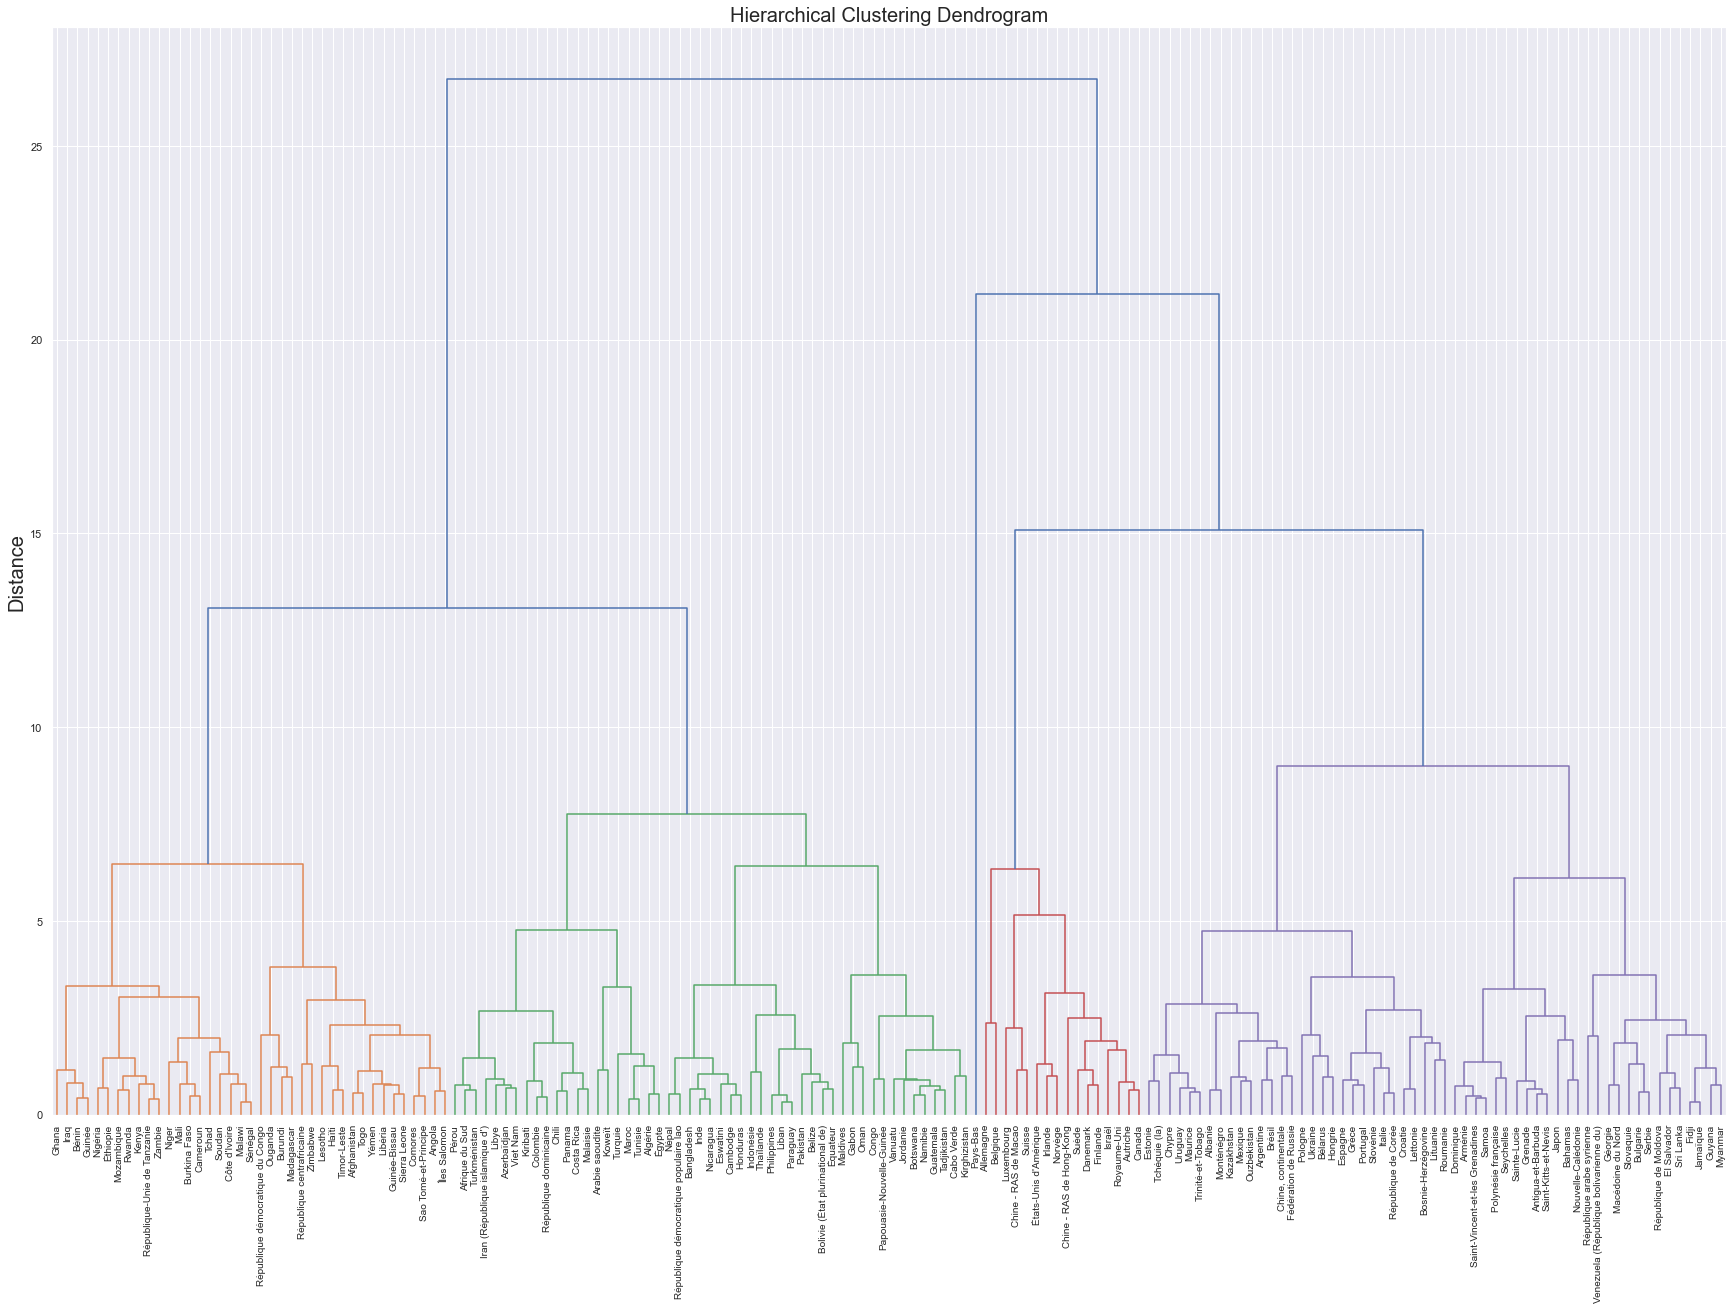

In [2560]:
# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')


# Affichage du dendrogramme
fig =plt.figure(figsize=(30,20))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.ylabel('Distance', fontsize=20)
dendrogram(Z, labels = names, leaf_font_size=10, color_threshold=11)
plt.savefig("p5_graphic/dendogramme.png")
plt.show()

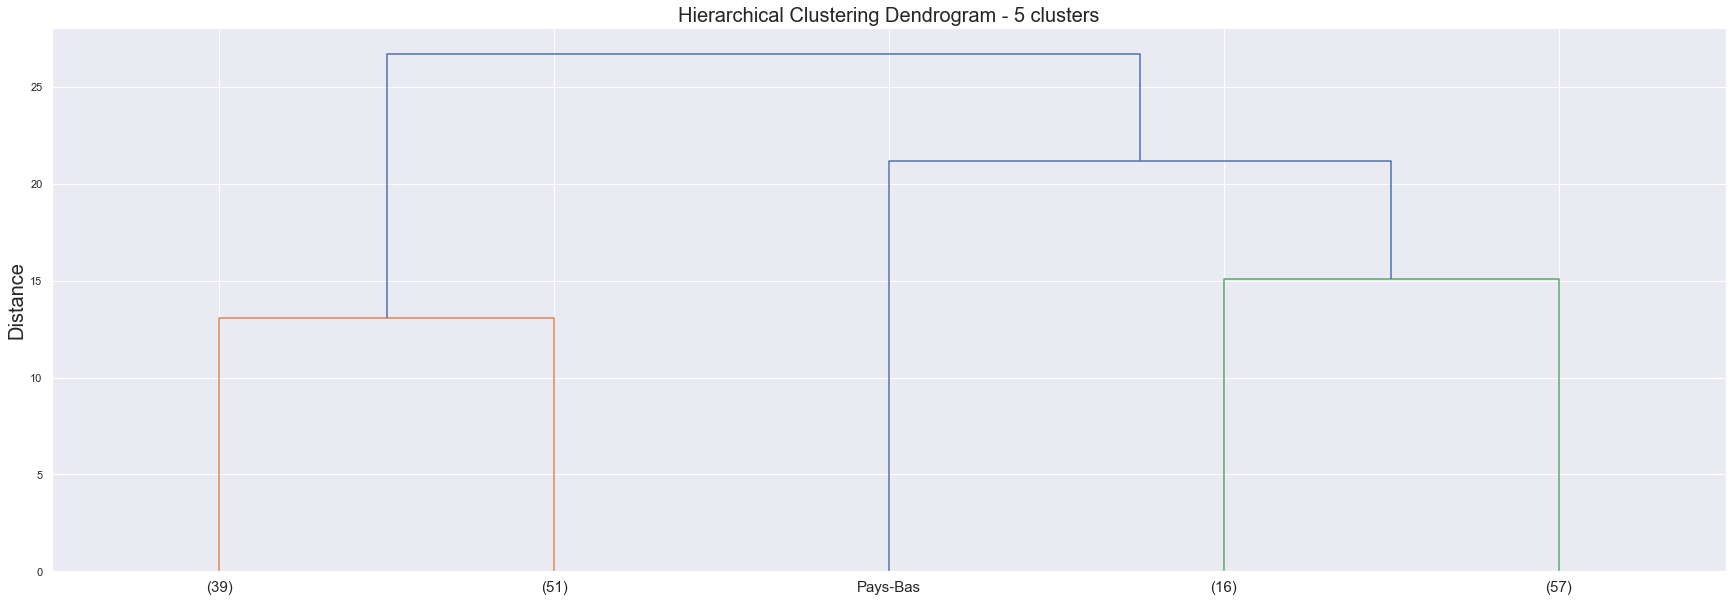

In [2561]:
fig = plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram - 5 clusters', fontsize=20)
plt.ylabel('Distance', fontsize=20)

dendrogram(Z, labels = names, p=5, truncate_mode='lastp', leaf_font_size=15)
plt.savefig("p5_graphic/dendogramme_5clusters.png")
plt.show()

In [2562]:
clusters = fcluster(Z, 5, criterion='maxclust')

#Index trié des groupes
idg = np.argsort(clusters)

#Affichage des pays selon leurs groupes
clusters_df = pd.DataFrame(names[idg], clusters[idg]).reset_index()
clusters_df = clusters_df.rename(columns={'index':'cluster'})

In [2563]:
data = data.merge(clusters_df, on='Pays')

In [2609]:
data

,Pays,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod,cluster
0,Afghanistan,9.537286,2273.0,57.31,18.042226,470,5736000.0,41.791045,1
1,Afrique du Sud,5.416661,2898.0,79.77,44.039112,6001,9959000.0,83.074108,2
2,Albanie,-0.333088,3338.0,116.02,53.844165,5303,5827000.0,35.294118,4
3,Algérie,7.723097,3493.0,90.84,26.519155,3976,32632000.0,101.393728,2
4,Allemagne,2.070995,3559.0,104.24,60.149655,46232,170013000.0,90.186916,3
...,...,...,...,...,...,...,...,...,...
159,Égypte,7.914811,3307.0,95.52,24.790620,3161,20666000.0,96.780684,2
160,Équateur,6.686224,2563.0,64.09,50.990794,6184,18264000.0,99.680511,2
161,États-Unis d'Amérique,2.487840,3862.0,115.01,66.020346,65134,8380000.0,118.465924,3
162,Éthiopie,10.031584,2439.0,70.55,9.071580,828,1952000.0,98.717949,1


In [2610]:
data.to_csv('pays.csv')

In [2564]:
data_cl1 = data[data.cluster == 1]
data_cl2 = data[data.cluster == 2]
data_cl3 = data[data.cluster == 3]
data_cl4 = data[data.cluster == 4]
data_cl5 = data[data.cluster == 5]

In [2565]:
c = data.groupby('cluster').mean()
c.to_csv('centroïdes.csv')
c

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod
cluster,,,,,,,
1,9.645242,2370.000000,57.710000,21.721494,1220.102564,2.290795e+06,65.838172
2,6.432755,2833.372549,76.817647,39.716954,6288.745098,8.617157e+06,80.537940
3,3.512114,3501.250000,111.283125,61.661102,62174.562500,3.427375e+07,86.886295
4,0.589694,3056.877193,91.017544,52.585730,13855.456140,1.221439e+07,76.366985
5,0.927822,3353.000000,108.110000,64.351124,53053.000000,7.080390e+08,695.302013


In [2566]:
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = st.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

In [2567]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

In [2568]:
tc = data.drop(['Pays', 'cluster'],axis=1)

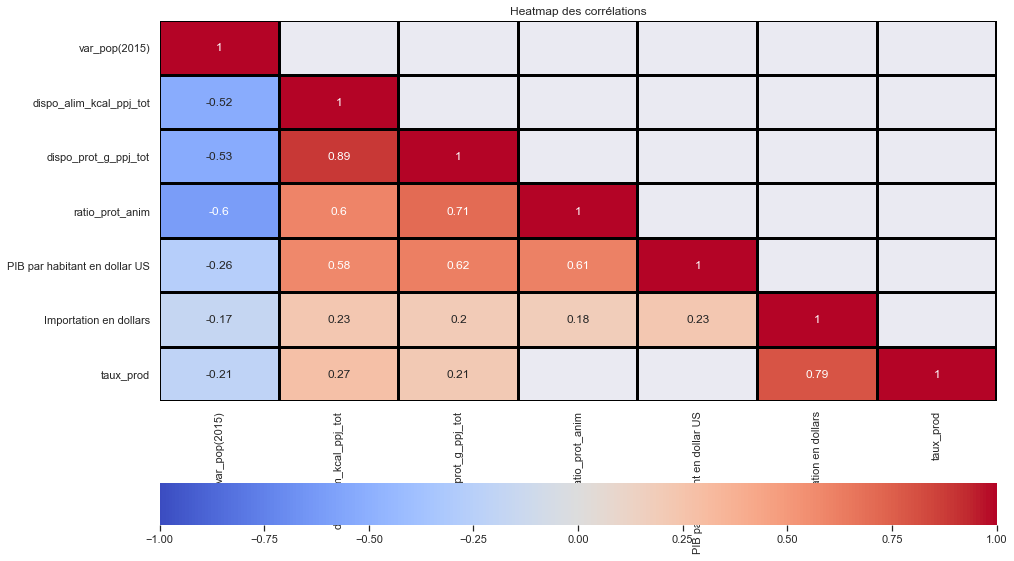

In [2570]:
# Plotting with significance filter
corr = tc.corr()                           # get correlation
p_values = corr_sig(tc)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr, mask) 
plt.title('Heatmap des corrélations')

plt.savefig("p5_graphic/heatmap.png")
plt.show()

### Cette heatmap nous permet de nous rendre compte des variables qui sont corrélées entre elles. Les valeurs affichées sur le tableau représente le coefficient de Pearson dont la corrélation est significative (p-value<5%). Nous pouvons déduire grâce à cela que:
### La variation de population est anti-corrélée à toutes les autres variables. Ce qui signifie par exemple que plus la variation est grande, moins le pays est riche ou encore moins le pays aura de disponibilité alimentaire.
### La variable "ratio_prot_anim" est corrélée à la disponibilité alimentaire, au PIB et à l'importation de poulet. Donc ici, plus le pays est consommateur de viande, plus il est riche, et peut etre enclin à importer du poulet.
### "taux_prod" est corrélée à l'importation de poulet. Ce qui signifie ici que plus le pays importe du poulet, plus il est producteur de viande de volailles.

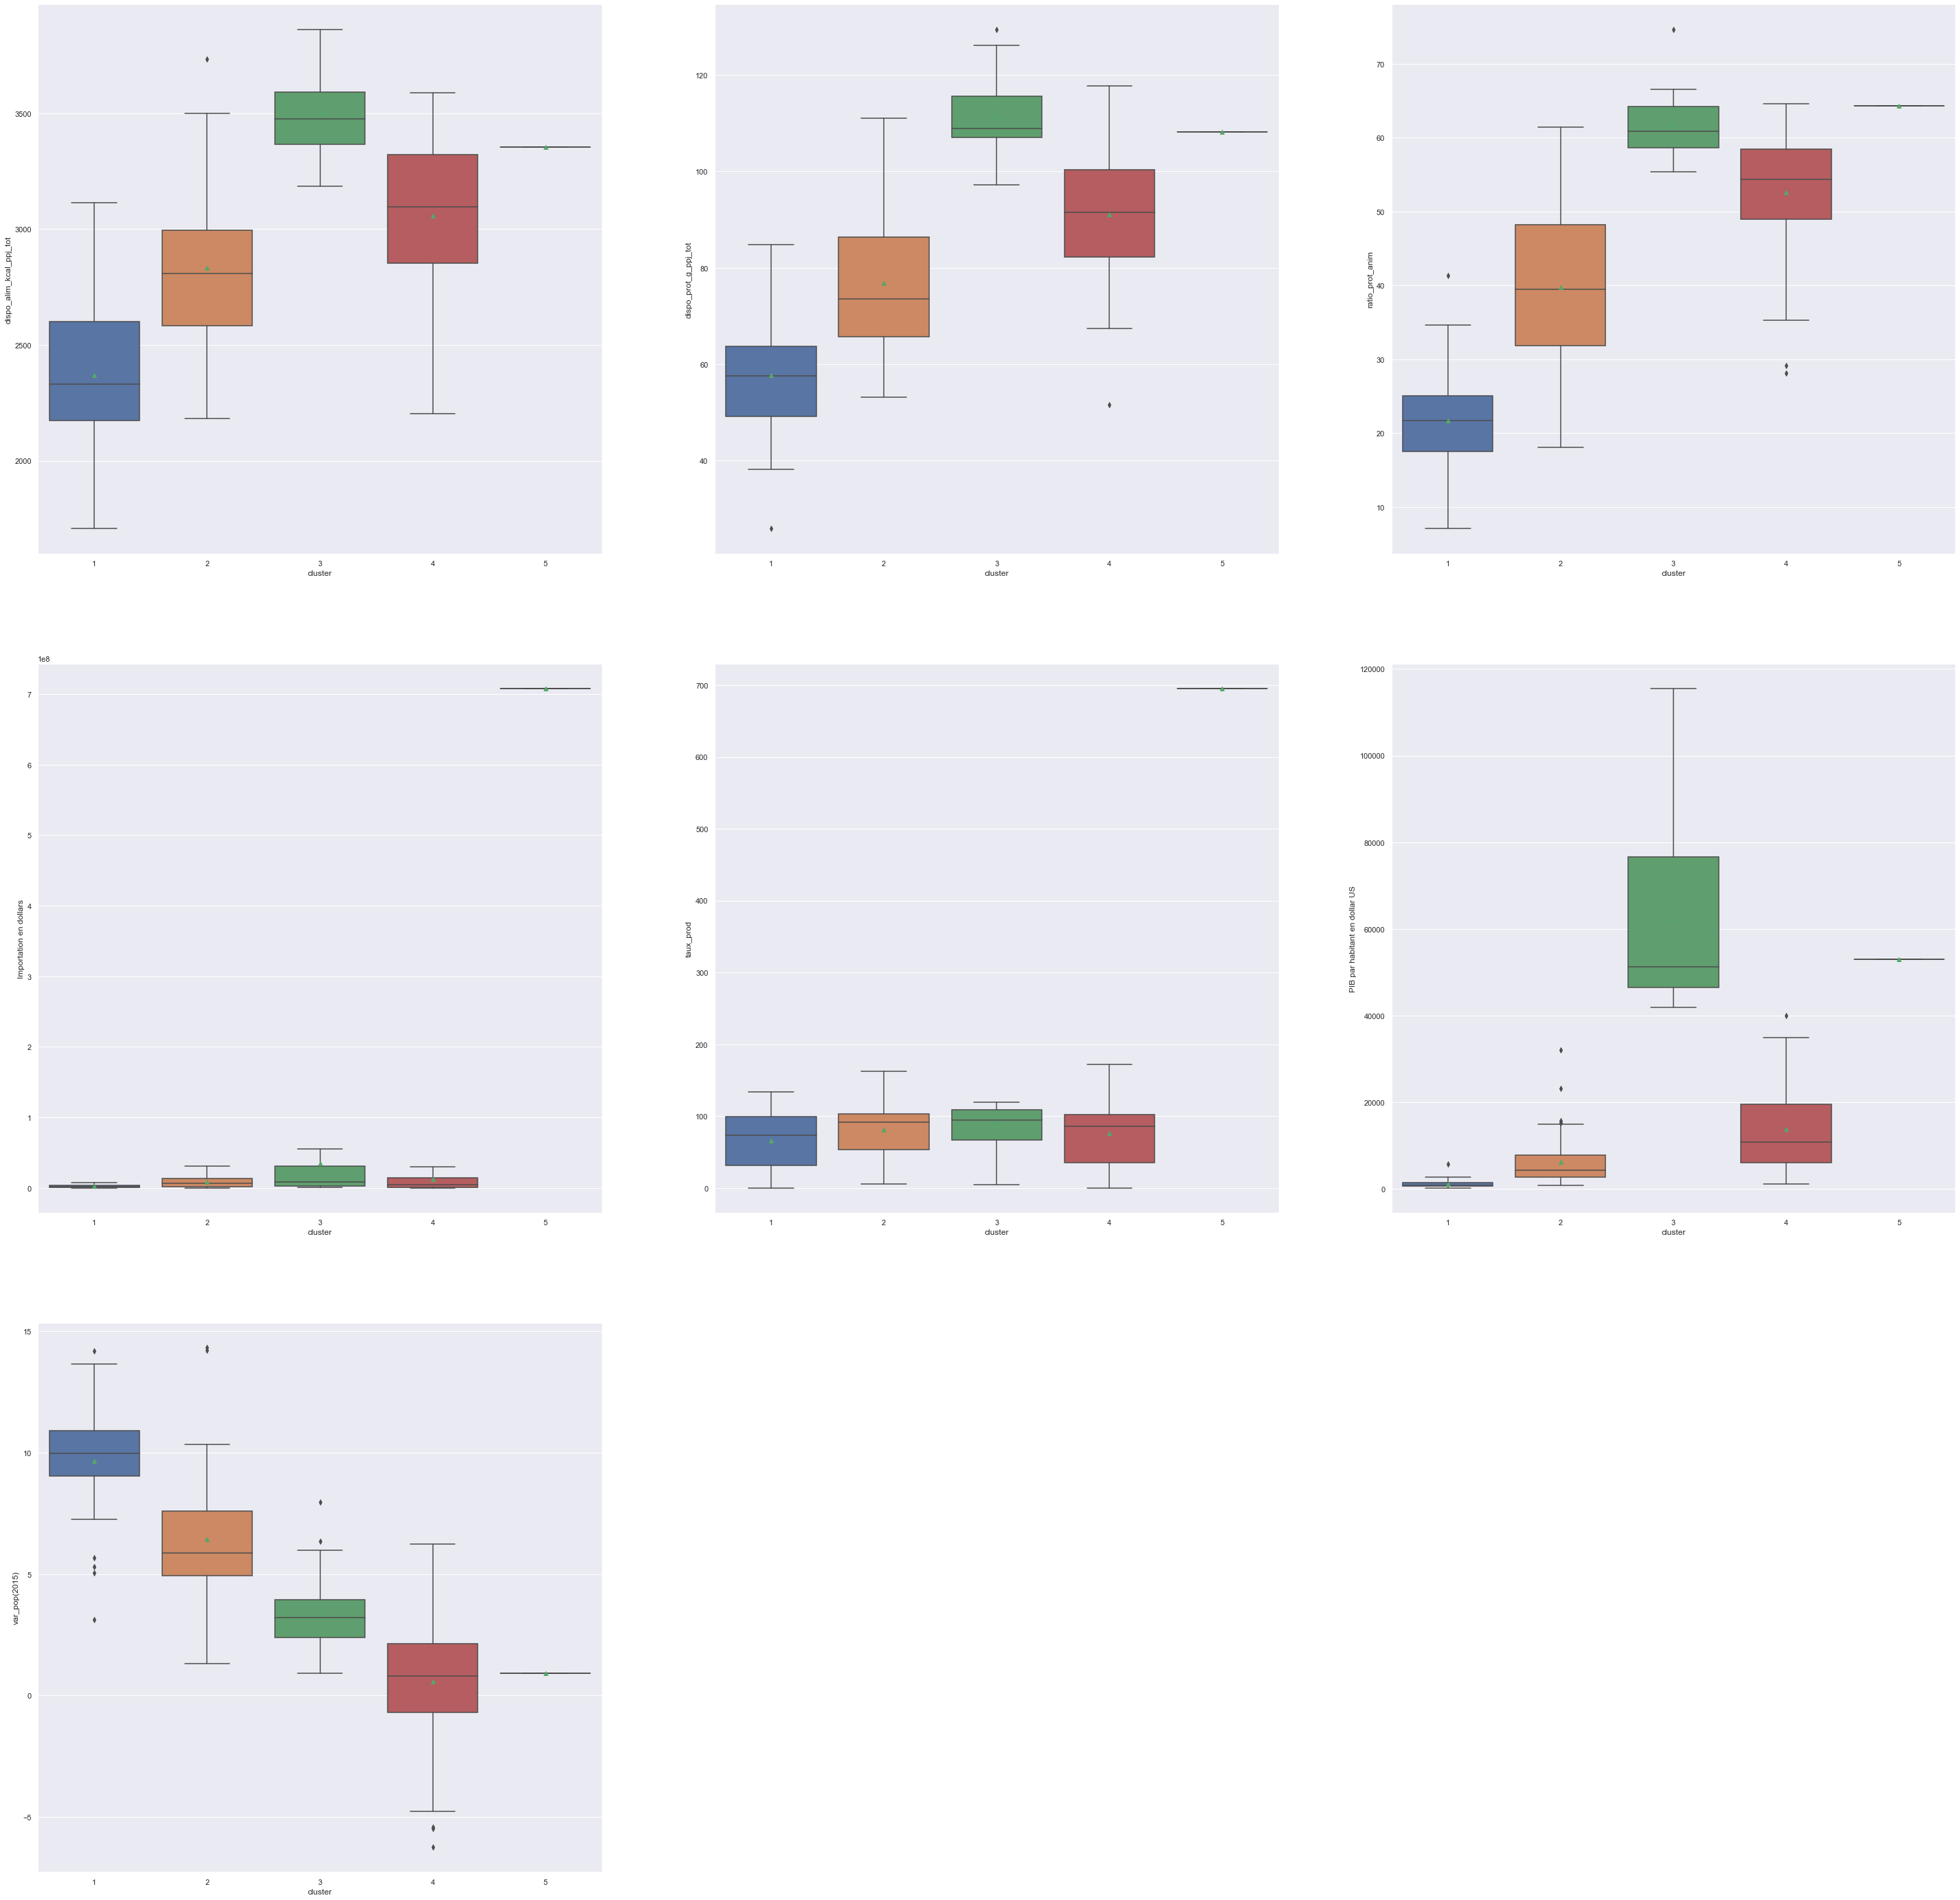

In [2571]:
#Comparaison visuelle des groupes par Boxplot, en abscisse les clusters
plt.figure(figsize=(50, 50))
sns.set()

plt.subplot(331)
sns.boxplot(data=data, x='cluster', y='dispo_alim_kcal_ppj_tot', showmeans=True)

plt.subplot(332)
sns.boxplot(data=data, x='cluster', y='dispo_prot_g_ppj_tot',showmeans=True)

plt.subplot(333)
sns.boxplot(data=data, x='cluster', y='ratio_prot_anim',showmeans=True)

plt.subplot(334)
sns.boxplot(data=data, x='cluster', y='Importation en dollars',showmeans=True, showfliers=False)

plt.subplot(335)
sns.boxplot(data=data, x='cluster', y='taux_prod',showmeans=True, showfliers=False)

plt.subplot(336)
sns.boxplot(data=data, x='cluster', y='PIB par habitant en dollar US',showmeans=True)

plt.subplot(337)
sns.boxplot(data=data, x='cluster', y='var_pop(2015)',showmeans=True)


plt.savefig("p5_graphic/boxplot.png")
plt.show()

### Cluster 1:Pays pauvres à faible disponibilité alimentaire et à variation de population la plus élevé. 
### Cluster 2: Pays en voie de développement moins importateurs et consommateurs de viandes.
### Cluster 3:Pays riches à forte disponibilité alimentaire et consommateurs de viandes.
### Cluster 4:Pays en voie de développement importateurs et consommateurs de viandes.
### Cluster 5:Pays-Bas

### Les pays du cluster 3 , avec les Pays-Bas, sont les plus riches, ceux qui consomment le plus de protéines animales, et également ceux qui importent le plus de viande de volaille par rapport aux autres clusters. Il est alors plus facile de vendre nos produits à ces pays. Etant donné que les Pays-Bas sont les premiers importateurs de poulets (de très loin) et présentent des valeurs qui sortent beaucoup trop du lot, nous allons d'ores et déjà les considérer comme cible de choix pour notre entreprise, et ainsi continuer l'analyse sans ce pays.Nous allons donc continuer notre analyse avec les pays du cluster 3 listé ci-dessous.

In [2573]:
data_cl3

,Pays,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod,cluster
4,Allemagne,2.070995,3559.0,104.24,60.149655,46232,170013000.0,90.186916,3
10,Autriche,3.086978,3691.0,108.95,59.192290,49701,38936000.0,74.576271,3
14,Belgique,2.178532,3800.0,100.34,60.374726,46198,193728000.0,239.572193,3
28,Canada,3.700434,3539.0,108.55,56.305850,46550,55688000.0,97.852960,3
30,Chine - RAS de Hong-Kong,3.364078,3236.0,129.45,74.662032,49180,1127000.0,4.318182,3
31,Chine - RAS de Macao,5.989585,3312.0,107.31,64.458112,84097,17000000.0,13.636364,3
40,Danemark,1.441143,3421.0,115.38,66.493326,60657,12117000.0,108.219178,3
47,Finlande,0.922497,3320.0,117.47,62.152039,48678,2359000.0,118.803419,3
65,Irlande,4.712140,3811.0,111.05,57.046376,81637,7667000.0,111.594203,3
66,Israël,6.348903,3558.0,126.10,60.563045,46376,3631000.0,100.816993,3


In [2622]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(20,20))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
        
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontsize=20)
            plt.savefig("p5_graphic/cercle_corr.png")
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(30,20))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='25', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=25)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=25)

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1), fontsize=25)
            plt.savefig("p5_graphic/proj_ind.png")
            plt.show(block=False)


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show()

In [2574]:
data_cl3.set_index('Pays', inplace=True)
data_cl3.drop(['cluster'],1, inplace=True)

C:\Users\denis\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


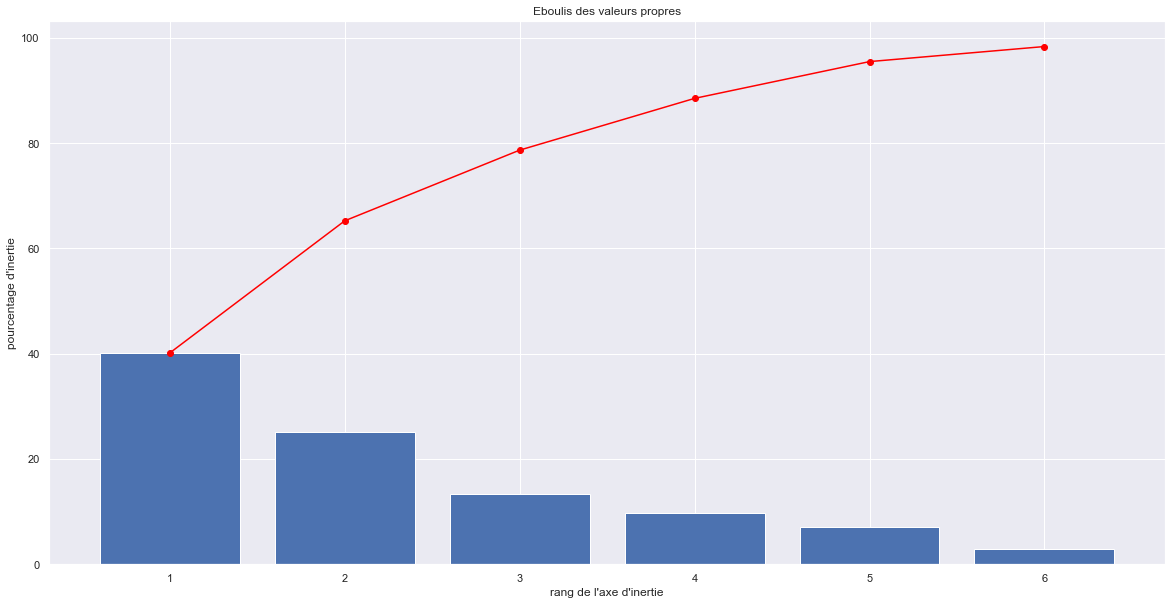

In [2575]:

# choix du nombre de composantes à calculer
n_comp = 6



# préparation des données pour l'ACP
X1 = data_cl3.values
names_1 = data_cl3.index
std_scale_1 = preprocessing.StandardScaler().fit(X1)
X1_scaled = std_scale_1.transform(X1)
features = data_cl3.columns


# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X1_scaled)
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red',marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig("p5_graphic/eboulis.png")
plt.show()

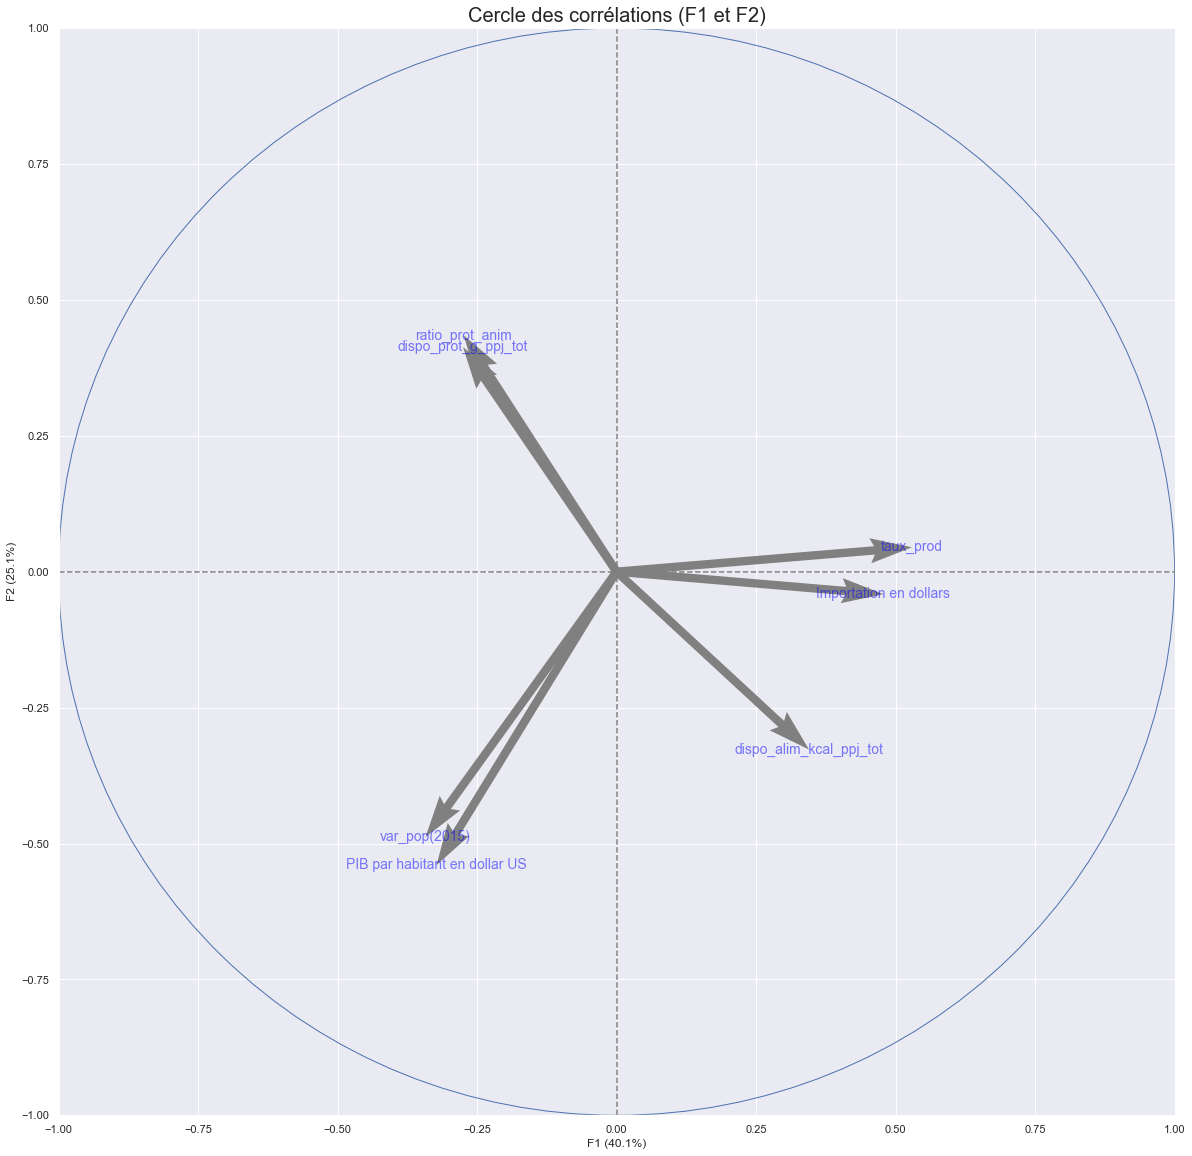

In [2623]:

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [2579]:
#Coefficients de la composante principale F1
F1 = pca.components_[0]
print(F1) 
#Coefficients de la composante principale F2
F2 = pca.components_[1]
print(F2)

[-0.34254614  0.34478214 -0.27506904 -0.2738017  -0.32266785  0.47822937
  0.52947068]
[-0.48828231 -0.32712944  0.41297453  0.43470368 -0.53974432 -0.04136899
  0.04490146]


### Ces coefficients nous permettent d'identifier les composantes F1 et F2, à savoir que:
### F1 correspond au marché du pays (importation, production)
### F2 correspond au régime alimentaire(ratio_prot_anim) en plus du PIB

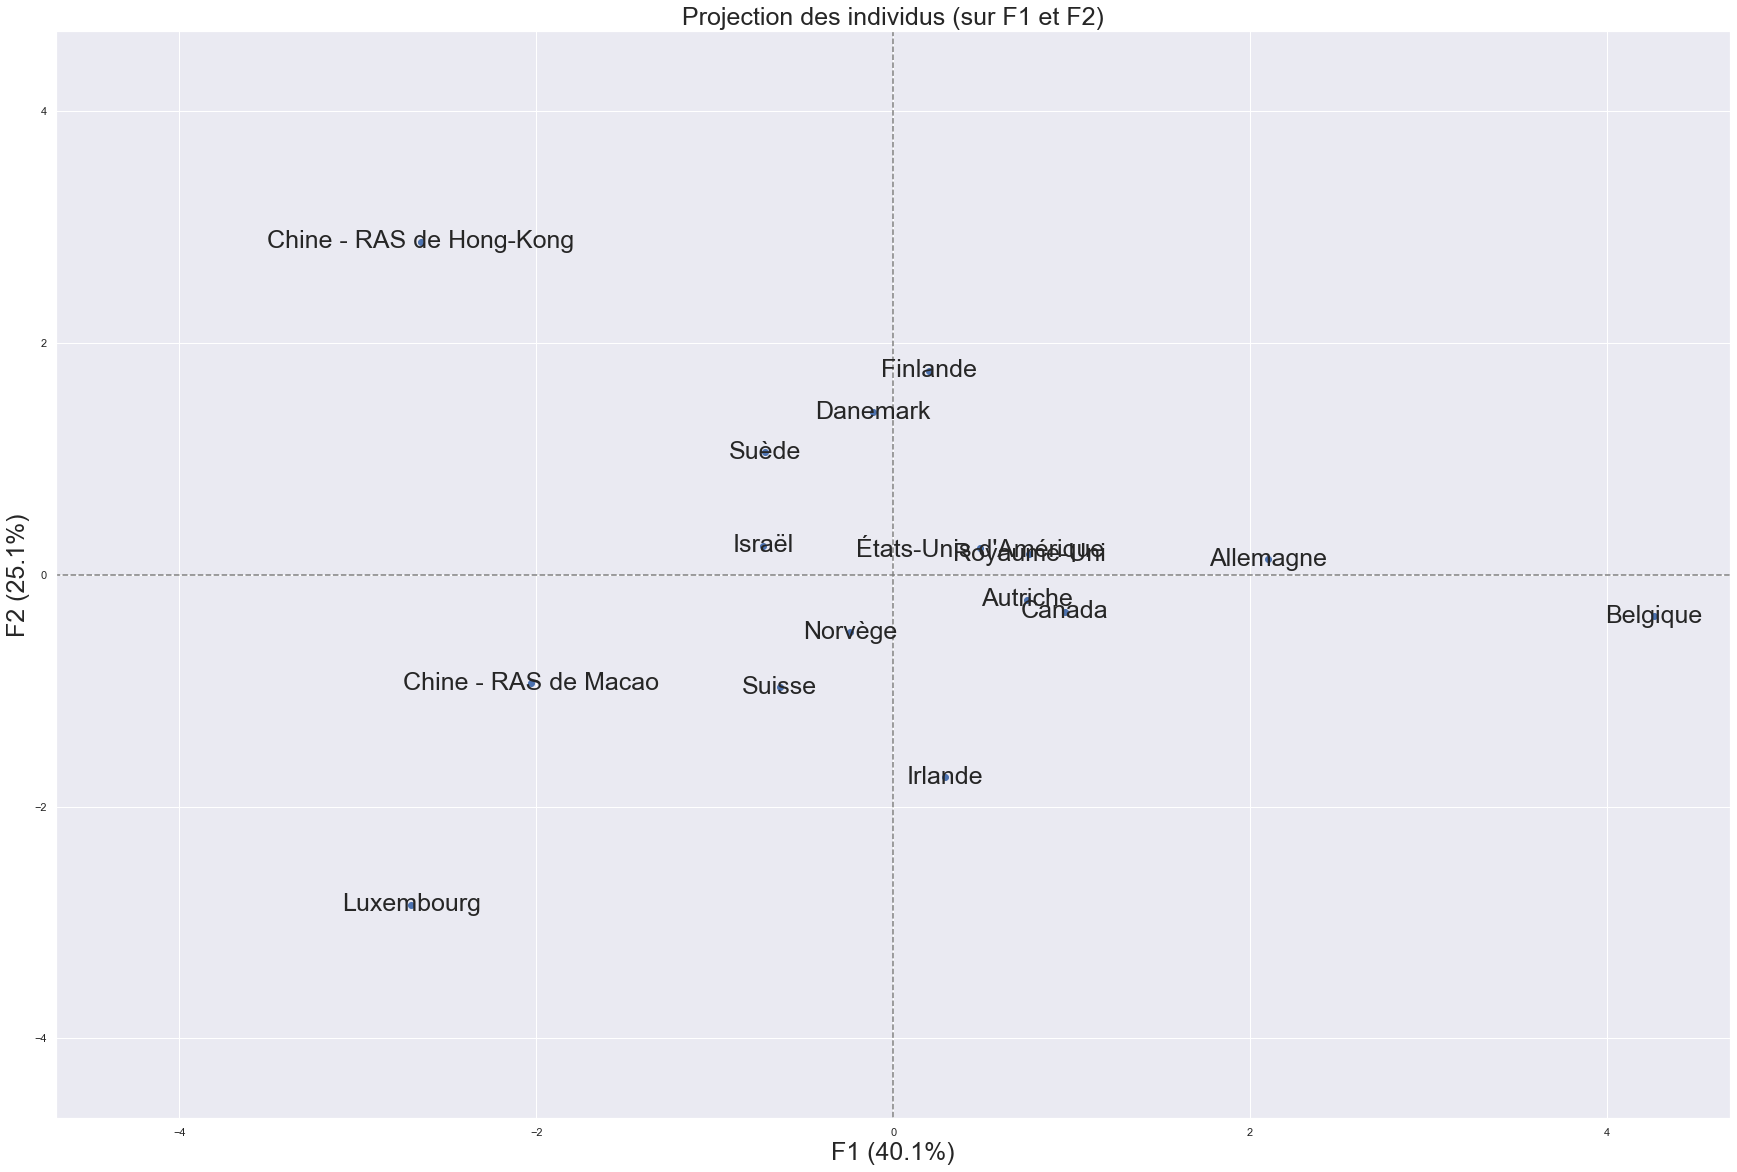

In [2624]:
# Projection des individus
X1_projected = pca.transform(X1_scaled)

display_factorial_planes(X1_projected, n_comp, pca,[(0,1)] , labels = np.array(names_1))

### Cette projection nous apporte une vision du potentiel des pays. Par exemple les pays les plus à droite importent le plus et produisent suffisement, ceux à gauche c'est le contraire. Ceux qui sont en bas présentent les plus hauts PIB/habitant mais sont moins consommateurs de viandes.

In [2578]:
df_facto = pd.DataFrame(X1_projected, index=data_cl3.index, columns=["F" + str(i+1) for i in range(6)]).iloc[:, :2]
df_facto

,F1,F2
Pays,,
Allemagne,2.102155,0.135612
Autriche,0.747494,-0.216221
Belgique,4.263146,-0.357528
Canada,0.962492,-0.320419
Chine - RAS de Hong-Kong,-2.647492,2.872882
Chine - RAS de Macao,-2.026629,-0.936750
Danemark,-0.114738,1.404295
Finlande,0.201135,1.758767
Irlande,0.288979,-1.745680


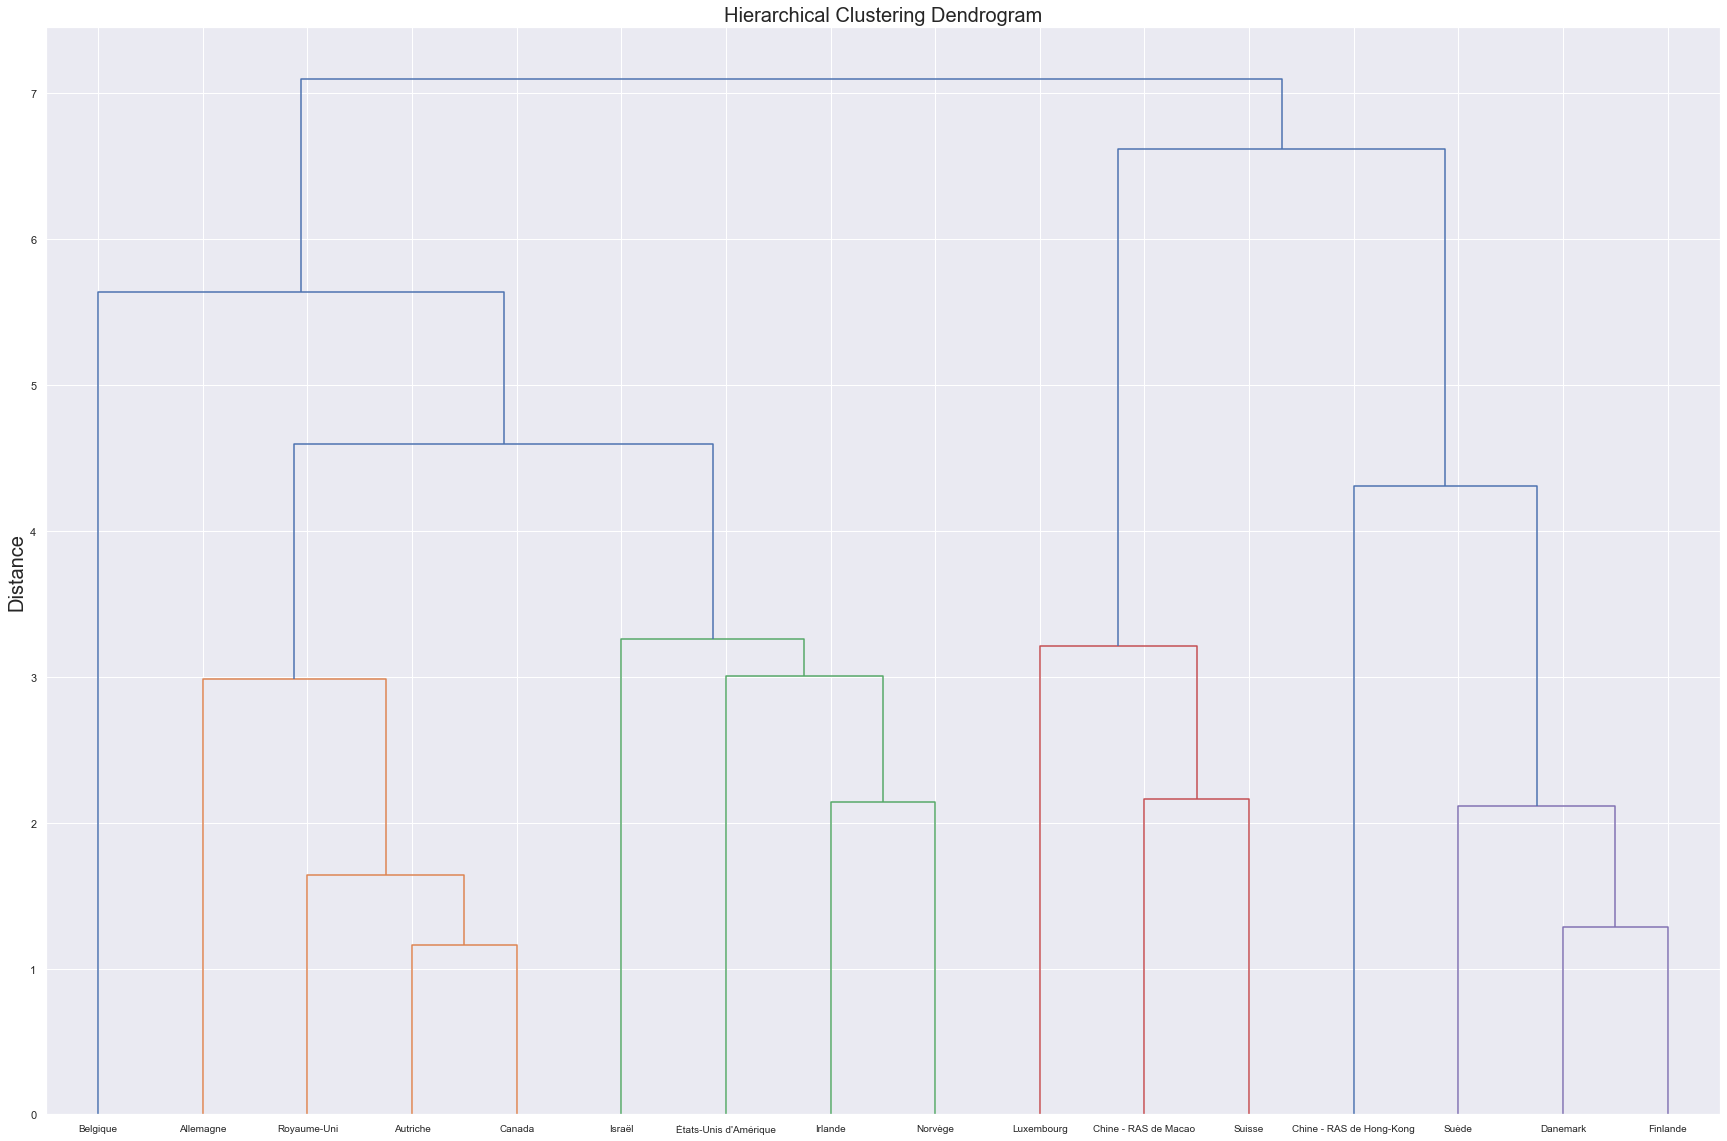

In [2581]:
# Clustering hiérarchique
Z1 = linkage(X1_scaled, 'ward')

# Affichage du dendrogramme
fig =plt.figure(figsize=(30,20))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.ylabel('Distance', fontsize=20)
dendrogram(Z1, labels = names_1, leaf_font_size=10, color_threshold=4)
plt.savefig('p5_graphic/dendrogramme_2.png')
plt.show()

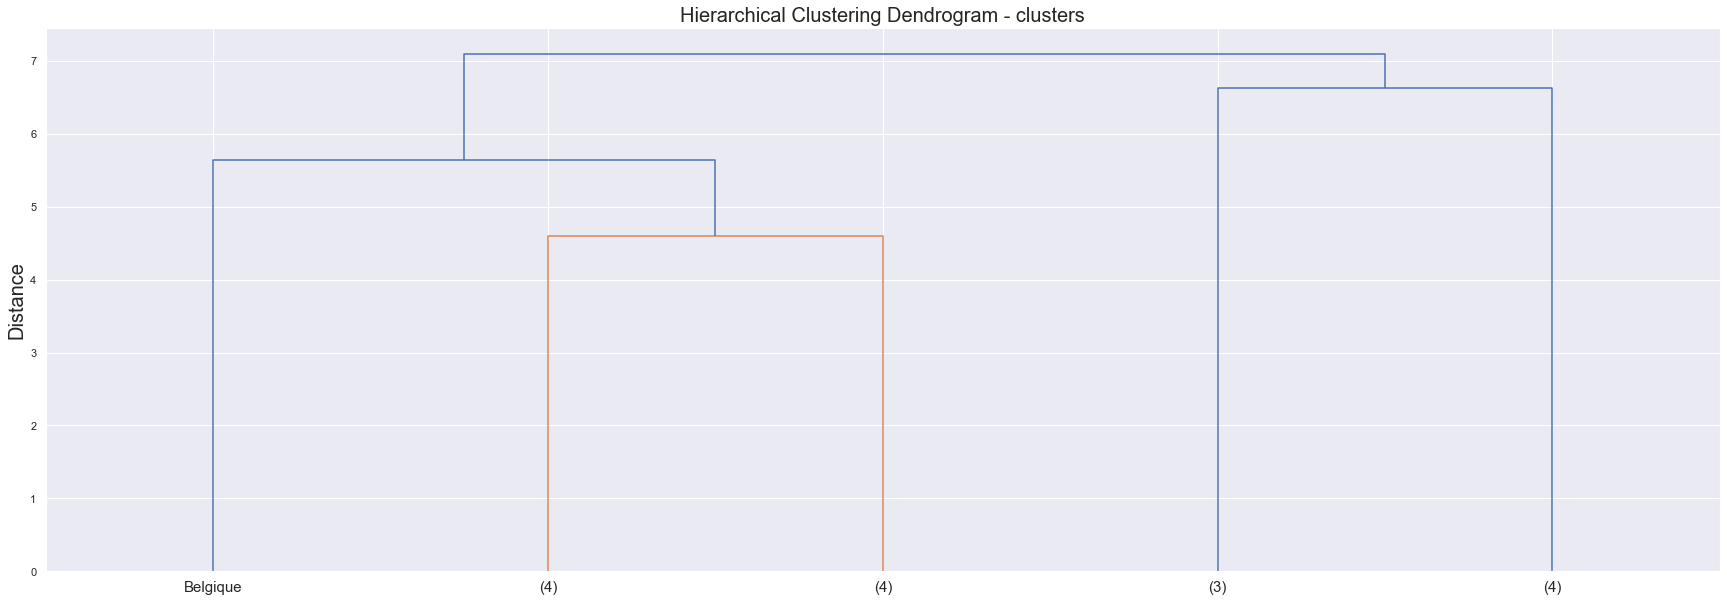

In [2625]:
fig = plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram - clusters', fontsize=20)
plt.ylabel('Distance', fontsize=20)

dendrogram(Z1, labels = names_1, p=5, truncate_mode='lastp', leaf_font_size=15)
plt.savefig('p5_graphic/dendrogramme_2_5c.png')
plt.show()

In [2583]:
clusters3 = fcluster(Z1, 5, criterion='maxclust')

#Index trié des groupes
idg = np.argsort(clusters3)

#Affichage des pays selon leurs groupes
clusters3_df = pd.DataFrame(names_1[idg], clusters3[idg]).reset_index()
clusters3_df = clusters3_df.rename(columns={'index':'cluster'})

In [2584]:
data_cl3 = data_cl3.merge(clusters3_df, on='Pays')
data_cl3.set_index('Pays', inplace=True)

In [2585]:
data_cl3.groupby('cluster').mean()

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod
cluster,,,,,,,
1,2.832854,3546.000000,106.982500,57.769186,46084.500000,73175250.0,86.009345
2,4.219279,3670.000000,117.110000,59.755481,67033.250000,4990750.0,107.260564
3,2.178532,3800.000000,100.340000,60.374726,46198.000000,193728000.0,239.572193
4,5.791530,3398.333333,104.473333,62.881092,94904.333333,6748000.0,26.693106
5,2.108042,3290.250000,117.600000,66.865240,52852.750000,5436000.0,74.362391


### Il nous apparaît clairement que 3 clusters ici sont les plus intéressant quant à notre politique d'exportation de poulet, à savoir:
###  Le cluster 3, qui est représenté par la seule Belgique, pays qui est le second importateur de poulet derrière les Pays-Bas.
### Le cluster 1, représenté par l'Allemagne, l'Autriche, le Canada et le Royaume-Uni, qui sont également de gros importateur de poulet.
### Le cluster 4, représenté par Macao, le Luxembourg et la Suisse, qui sont les pays les plus riches en termes de PIB par habitant, et qui ont une certaine dépendance à l'importation de poulet.
### Les 9 pays sus-cités représente alors notre liste de clients à fort potentiel pour notre entreprise.

### La division des 16 pays en plusieurs groupes nous ont permis de sélectionner les pays les plus à même d'importer nos produits, nous allons cependant vérifier que ces groupes diffèrent vraiment, à l'aide de tests d'adéquation et de comparaison.
### Nous allons commencer par le test d'adéquation, qui nous permettra de récupérer les variables gaussiennes, sur lesquelles nous allons effectuer nos tests de comparaison.

In [2586]:
liste = list(data_cl3.columns)
del liste[-1]

In [2587]:
liste_2=[] #Liste des distributions gaussiennes
for col in liste:
    stat, p = shapiro(data_cl3[col])
    if p > 0.05:#Si p>0.05, la variable est gaussienne
        liste_2.append(col)
    print(f'{col}:Statistics={round(stat, 3)}, p={round(p, 3)}')

var_pop(2015):Statistics=0.911, p=0.119
dispo_alim_kcal_ppj_tot:Statistics=0.953, p=0.534
dispo_prot_g_ppj_tot:Statistics=0.952, p=0.527
ratio_prot_anim:Statistics=0.921, p=0.177
PIB par habitant en dollar US:Statistics=0.829, p=0.007
Importation en dollars:Statistics=0.603, p=0.0
taux_prod:Statistics=0.873, p=0.03


### Nous recensons 4 variables qui ne peuvent pas rejeter l'hypothèse H0, ce qui impliquent que ces 4 variables suivent une loi normale, car leur p-valeur est supérieur à 5%(niveau de test). Voici une liste de ces variables dites gaussiennes.

In [2588]:
liste_2

['var_pop(2015)',
 'dispo_alim_kcal_ppj_tot',
 'dispo_prot_g_ppj_tot',
 'ratio_prot_anim']

In [2589]:
d31 = data_cl3[data_cl3.cluster == 1]
d32 = data_cl3[data_cl3.cluster == 2]
d33 = data_cl3[data_cl3.cluster == 3]
d34 = data_cl3[data_cl3.cluster == 4]
d35 = data_cl3[data_cl3.cluster == 5]

In [2590]:
d31

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod,cluster
Pays,,,,,,,,
Allemagne,2.070995,3559.0,104.24,60.149655,46232,170013000.0,90.186916,1
Autriche,3.086978,3691.0,108.95,59.192290,49701,38936000.0,74.576271,1
Canada,3.700434,3539.0,108.55,56.305850,46550,55688000.0,97.852960,1
Royaume-Uni,2.473009,3395.0,106.19,55.428948,41855,28064000.0,81.421233,1


In [2608]:
d34

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod,cluster
Pays,,,,,,,,
Chine - RAS de Macao,5.989585,3312.0,107.31,64.458112,84097,17000000.0,13.636364,4
Luxembourg,7.956098,3504.0,108.95,61.083066,115481,539000.0,0.000000,4
Suisse,3.428908,3379.0,97.16,63.102100,85135,2705000.0,66.442953,4


In [2599]:
d35

,var_pop(2015),dispo_alim_kcal_ppj_tot,dispo_prot_g_ppj_tot,ratio_prot_anim,PIB par habitant en dollar US,Importation en dollars,taux_prod,cluster
Pays,,,,,,,,
Chine - RAS de Hong-Kong,3.364078,3236.0,129.45,74.662032,49180,1127000.0,4.318182,5
Danemark,1.441143,3421.0,115.38,66.493326,60657,12117000.0,108.219178,5
Finlande,0.922497,3320.0,117.47,62.152039,48678,2359000.0,118.803419,5
Suède,2.704451,3184.0,108.10,64.153562,52896,6141000.0,66.108787,5


### Nous allons maintenant effectuer des tests de comparaison sur les variables gaussiennes. Pour montrer que des groupe diffèrent, il faut tester l'égalité des variances puis l'égalisté des moyennes.

In [2600]:
for col in liste_2:
    print(col,bartlett(d31[col],d35[col]))#Test de l'égalité des variances
    print(col,st.ttest_ind(d31[col],d35[col]))#Test de l'égalité des moyennes

var_pop(2015) BartlettResult(statistic=0.5119230235594289, pvalue=0.47430757677839097)
var_pop(2015) Ttest_indResult(statistic=1.0895220165666786, pvalue=0.31773634911539667)
dispo_alim_kcal_ppj_tot BartlettResult(statistic=0.062655531524395, pvalue=0.8023469511235679)
dispo_alim_kcal_ppj_tot Ttest_indResult(statistic=3.208241995466104, pvalue=0.018407762865570724)
dispo_prot_g_ppj_tot BartlettResult(statistic=3.9152173767408383, pvalue=0.04785082671797153)
dispo_prot_g_ppj_tot Ttest_indResult(statistic=-2.3257345752159884, pvalue=0.058984070549778174)
ratio_prot_anim BartlettResult(statistic=1.8079967600886346, pvalue=0.17874872429456157)
ratio_prot_anim Ttest_indResult(statistic=-3.0632975519059538, pvalue=0.02213126388409438)


### Les tests d'égalité s'interprêtent de la façon suivante: Soit H0 l'hypothèse d'égalité(variance ou moyenne)
### Si la p-value > 0.05, H0 n'est pas rejetée, il y a alors égalité.
### Dans le cas contraire, il n'y a alors pas d'égalité.
### Par exemple dans notre cas, les variables "ratio_prot_anim" et "dispo_alim_kcal_ppj_tot" présentent des p-value inférieure à 0.05 dans le cadre du test des moyennes. Et la variable "dispo_prot_g_ppj_tot" présente une p-value inférieure à 0.05 dans le cadre du test des variances. Ces tests notre montre bien que les 2 groupes ainsi testés sont différents.
### Nous trouverons au moins une variable gaussienne dont les tests rejeterons H0 pour chaque paire de groupes.

In [2601]:
round(d31['ratio_prot_anim'].mean(), 2)

57.77

In [2602]:
round(d35['ratio_prot_anim'].mean(), 2)

66.87

In [2603]:
round(d31['dispo_alim_kcal_ppj_tot'].mean(), 2)

3546.0

In [2604]:
round(d35['dispo_alim_kcal_ppj_tot'].mean(), 2)

3290.25

In [2605]:
round(d31['var_pop(2015)'].mean(), 2)

2.83

In [2606]:
round(d35['var_pop(2015)'].mean(), 2)

2.11